# CSCB Project

In [83]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import scipy as sp
import numpy as np
import anndata
import pySingleCellNet as pySCN
sns.set_style('white')

## Read in Data

In [84]:
# read in data
#mcm raw is our engineered mouse cardiomyocytes
adata_mcm_raw=sc.read_h5ad('direct_conversion_subsampled_5k_raw.h5ad')

#this is the reference dataset from the tabula muris study
adata_tabmuris=sc.read_h5ad('TM_FACS_heart.h5ad')

In [85]:
# metadata was labeled as batch, translating this to timepoint
adata_mcm_raw.obs['Timepoint (days)']=adata_mcm_raw.obs['batch'].map({'1':'-1','2':'1','3':'2','4':'3','5':'7','6':'14'})

In [86]:
#mt and ribo genes, qc metrics
adata_mcm_raw.var['mt']= adata_mcm_raw.var_names.str.startswith(("mt-"))
adata_mcm_raw.var['ribo'] = adata_mcm_raw.var_names.str.startswith(("Rps","Rpl"))
sc.pp.calculate_qc_metrics(adata_mcm_raw, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

## Q1

In [111]:
#finding matching genes between datasets
genesTrain = adata_tabmuris.var_names
genesQuery = adata_mcm_raw.var_names
cgenes = genesTrain.intersection(genesQuery)
#around 14k genes remanining

In [112]:
#subsetting for common genes
adata_reference_cgene = adata_tabmuris[:,cgenes]
adata_mcm_raw = adata_mcm_raw[:,cgenes].copy()

#following the pyscCellNet vignette on github. im guessing cells with more than 500 
adata_mcm_classifier = adata_mcm_raw[adata_mcm_raw.obs["n_genes_by_counts"]>=500,:].copy()




In [113]:
adata_reference_cgene.obs['cell_ontology_class'].unique()

['endothelial cell', 'leukocyte', 'fibroblast', 'myofibroblast cell', 'endocardial cell', 'cardiac muscle cell', 'smooth muscle cell']
Categories (7, object): ['cardiac muscle cell', 'endocardial cell', 'endothelial cell', 'fibroblast', 'leukocyte', 'myofibroblast cell', 'smooth muscle cell']

In [114]:
expTrain, expVal = pySCN.splitCommonAnnData(adata_reference_cgene, ncells=200,dLevel='cell_ontology_class')



endocardial cell : 
165
smooth muscle cell : 
42
myofibroblast cell : 
178
leukocyte : 
523
cardiac muscle cell : 
133
fibroblast : 
2119
endothelial cell : 
1177


In [115]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 0,
                                           nTrees = 1000 ,nTopGenePairs = 100, dLevel = 'cell_ontology_class', 
                                           stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  725  classification genes

cardiac muscle cell
endocardial cell
endothelial cell
fibroblast
leukocyte
myofibroblast cell
smooth muscle cell
There are 691 top gene pairs

Finished pair transforming the data



<Figure size 6000x4000 with 0 Axes>

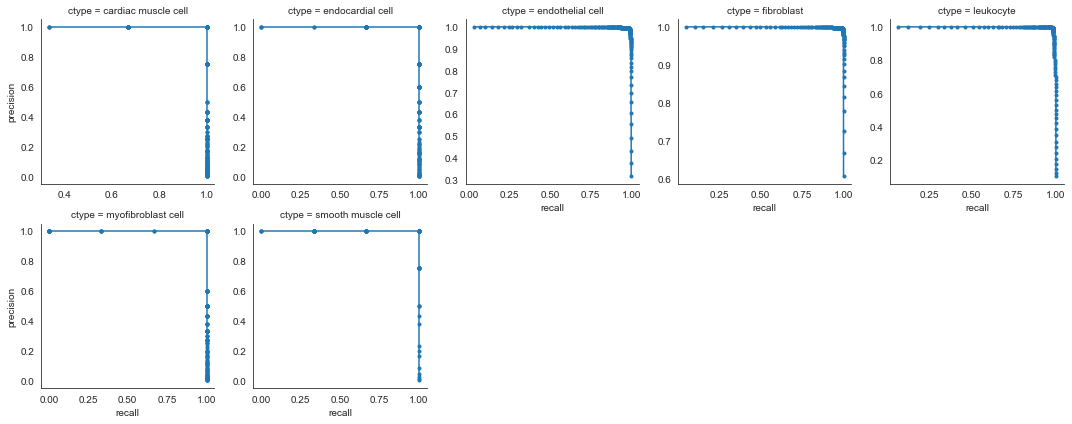

<Figure size 432x288 with 0 Axes>

In [116]:
#classifier on held out test set
plt.figure(dpi=1000)
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)
assessment =  pySCN.assess_comm(expTrain, adVal, resolution = 0.005, nRand = 0, dLevelSID = "cell", classTrain = "cell_ontology_class", classQuery = "cell_ontology_class")

pySCN.plot_PRs(assessment)
plt.show()
plt.savefig("pyscn_testsetprc.png") #save as png

In [117]:
#use classifier on old hsc data
adata_mcm_classified = pySCN.scn_classify(adata_mcm_classifier, cgenesA, xpairs, tspRF, nrand = 0)



In [118]:
props={}
for i in adata_mcm_classified.obs['Timepoint (days)'].unique():
    props[i]={}
    for j in adata_mcm_classified[adata_mcm_classified.obs['Timepoint (days)']==i].obs['SCN_class'].unique():
        props[i][j]=sum(adata_mcm_classified[adata_mcm_classified.obs['Timepoint (days)']==i].obs['SCN_class']==j)

In [119]:
scn_calls=pd.DataFrame(props).fillna(0)
scn_calls.update(scn_calls.div(scn_calls.sum(axis=0),axis=1))
scn_calls=scn_calls[['-1','1','2','3','7','14']]

In [120]:
scn_calls

,-1,1,2,3,7,14
cardiac muscle cell,0.000000,0.001675,0.025273,0.064148,0.187938,0.735023
fibroblast,0.892473,0.872697,0.844262,0.816344,0.611501,0.165899
leukocyte,0.095238,0.120603,0.116803,0.106327,0.190743,0.094470
myofibroblast cell,0.000000,0.001675,0.004098,0.000879,0.000000,0.004608
endothelial cell,0.007680,0.000000,0.006831,0.001757,0.002805,0.000000
endocardial cell,0.004608,0.003350,0.002732,0.010545,0.007013,0.000000


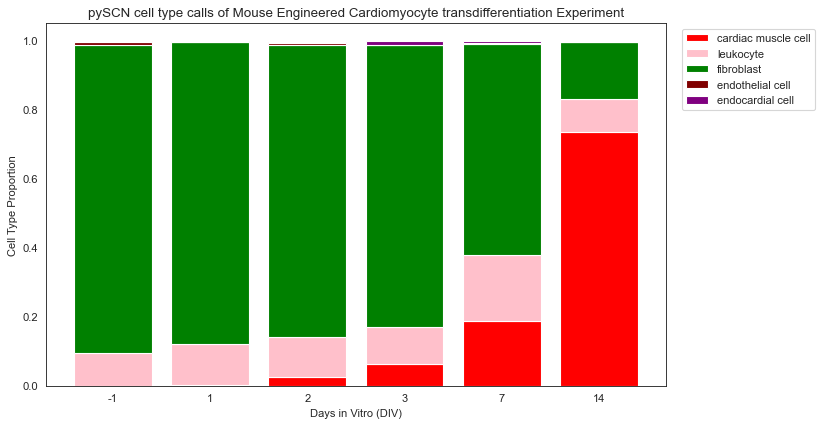

In [121]:
plt.figure(figsize=(10, 6), dpi=80)

plt.bar(scn_calls.columns,scn_calls.loc['cardiac muscle cell'],color='red')
#plt.bar(scn_calls.columns, scn_calls.loc['rand'], bottom=scn_calls.loc['cardiac muscle cell'], color='grey')
plt.bar(scn_calls.columns, scn_calls.loc['leukocyte'], bottom=scn_calls.loc['cardiac muscle cell'], color='pink')
plt.bar(scn_calls.columns, scn_calls.loc['fibroblast'], bottom=scn_calls.loc['leukocyte']+scn_calls.loc['cardiac muscle cell'], color='green')
plt.bar(scn_calls.columns, scn_calls.loc['endothelial cell'], bottom=scn_calls.loc['leukocyte']+scn_calls.loc['cardiac muscle cell']+scn_calls.loc['fibroblast'], color='maroon')
plt.bar(scn_calls.columns, scn_calls.loc['endocardial cell'], bottom=scn_calls.loc['leukocyte']+scn_calls.loc['cardiac muscle cell']+scn_calls.loc['fibroblast']+scn_calls.loc['endothelial cell'], color='purple')


plt.legend(["cardiac muscle cell", "leukocyte", "fibroblast",'endothelial cell','endocardial cell'],loc='upper right',bbox_to_anchor=(1.25, 1.0))
plt.xlabel('Days in Vitro (DIV)')
plt.ylabel('Cell Type Proportion')
plt.title('pySCN cell type calls of Mouse Engineered Cardiomyocyte transdifferentiation Experiment')
plt.savefig("pyscn_stackedbarplot.png") #save as png


## Q2

In [16]:
adata_kannan=sc.read_h5ad('Kannan_perinatal_reference.h5ad')

In [30]:
adata_kannan #raw counts

AnnData object with n_obs × n_vars = 936 × 29593
    obs: 'i7', 'cellbarcode', 'column', 'timepoint', 'genes', 'umis', 'ERCC_percent', 'reads'

In [130]:
adata_mcm_raw.obs['scn_class']=adata_mcm_classified.obs['SCN_class']
adata_mcm_classifier_mcmcalls=adata_mcm_raw[adata_mcm_raw.obs['scn_class']=='cardiac muscle cell']

In [131]:
#finding matching genes between datasets
genesTrain = adata_kannan.var_names
genesQuery = adata_mcm_classifier_mcmcalls.var_names
cgenes = genesTrain.intersection(genesQuery)
#around 14k genes remanining

In [132]:
#subsetting for common genes
adata_reference_cgene = adata_kannan[:,cgenes]
adata_mcm_classifier_mcmcalls = adata_mcm_classifier_mcmcalls[:,cgenes].copy()

#following the pyscCellNet vignette on github. im guessing cells with more than 500 
adata_mcm_classifier_mcmcalls = adata_mcm_classifier_mcmcalls[adata_mcm_classifier_mcmcalls.obs["n_genes_by_counts"]>=500,:].copy()





In [133]:
adata_reference_cgene.obs['timepoint'].unique()

['e18', 'e14', 'p0', 'p4', 'p14', ..., 'p35', 'p56', 'p18', 'p11', 'p8']
Length: 12
Categories (12, object): ['e14', 'e18', 'p0', 'p4', ..., 'p22', 'p28', 'p35', 'p56']

In [134]:
expTrain, expVal = pySCN.splitCommonAnnData(adata_reference_cgene, ncells=200,dLevel='timepoint')




e14 : 
72
e18 : 
83
p56 : 
94
p0 : 
35
p18 : 
89
p11 : 
93
p14 : 
92
p22 : 
92
p35 : 
91
p8 : 
82
p4 : 
36
p28 : 
77


In [135]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 0,
                                           nTrees = 1000 ,nTopGenePairs = 100, dLevel = 'timepoint', 
                                           stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  1237  classification genes

e14
e18
p0
p11
p14
p18
p22
p28
p35
p4
p56
p8
There are 1166 top gene pairs

Finished pair transforming the data



<Figure size 6000x4000 with 0 Axes>

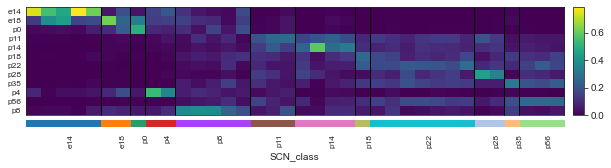

In [164]:
plt.figure(dpi=1000)
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)


In [165]:
#use classifier on old hsc data
adata_mcm_classified = pySCN.scn_classify(adata_mcm_classifier_mcmcalls, cgenesA, xpairs, tspRF, nrand = 0)




In [169]:
props={}
for i in adata_mcm_classified.obs['Timepoint (days)'].unique():
    props[i]={}
    for j in adata_mcm_classified[adata_mcm_classified.obs['Timepoint (days)']==i].obs['SCN_class'].unique():
        props[i][j]=sum(adata_mcm_classified[adata_mcm_classified.obs['Timepoint (days)']==i].obs['SCN_class']==j)

In [170]:
scn_calls=pd.DataFrame(props).fillna(0)
scn_calls.update(scn_calls.div(scn_calls.sum(axis=0),axis=1))
#scn_calls=scn_calls[['-1','1','2','3','7','14']]

In [185]:
scn_calls=scn_calls[['1','2','3','7','14']]

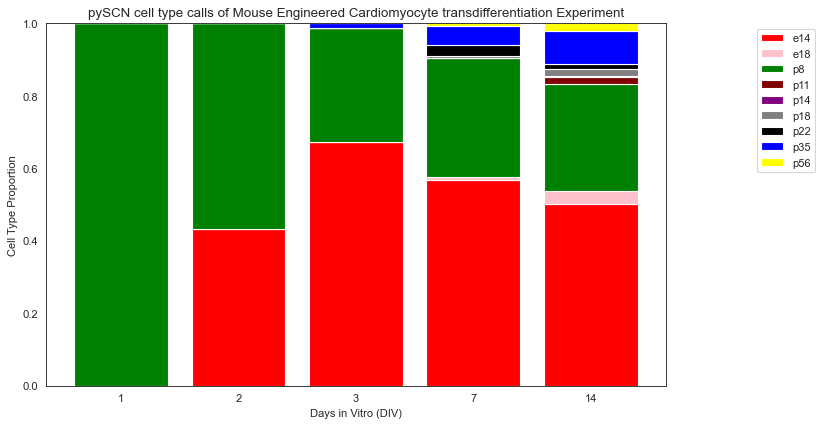

In [186]:
plt.figure(figsize=(10, 6), dpi=80)

plt.bar(scn_calls.columns,scn_calls.loc['e14'],color='red')
#plt.bar(scn_calls.columns, scn_calls.loc['rand'], bottom=scn_calls.loc['cardiac muscle cell'], color='grey')
plt.bar(scn_calls.columns, scn_calls.loc['e18'], bottom=scn_calls.loc['e14'], color='pink')
plt.bar(scn_calls.columns, scn_calls.loc['p8'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18'], color='green')
plt.bar(scn_calls.columns, scn_calls.loc['p11'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p8'], color='maroon')
plt.bar(scn_calls.columns, scn_calls.loc['p14'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p8']+scn_calls.loc['p11'], color='purple')
plt.bar(scn_calls.columns, scn_calls.loc['p18'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p8']+scn_calls.loc['p11']+scn_calls.loc['p14'], color='grey')
plt.bar(scn_calls.columns, scn_calls.loc['p22'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p8']+scn_calls.loc['p11']+scn_calls.loc['p14']+scn_calls.loc['p18'], color='black')
plt.bar(scn_calls.columns, scn_calls.loc['p35'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p8']+scn_calls.loc['p11']+scn_calls.loc['p14']+scn_calls.loc['p18']+scn_calls.loc['p22'], color='blue')
plt.bar(scn_calls.columns, scn_calls.loc['p56'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p8']+scn_calls.loc['p11']+scn_calls.loc['p14']+scn_calls.loc['p18']+scn_calls.loc['p22']+scn_calls.loc['p35'], color='yellow')





plt.legend(["e14", "e18", "p8",'p11','p14','p18','p22','p35','p56'],loc='upper right',bbox_to_anchor=(1.25, 1.0))
plt.xlabel('Days in Vitro (DIV)')
plt.ylabel('Cell Type Proportion')
plt.title('pySCN cell type calls of Mouse Engineered Cardiomyocyte transdifferentiation Experiment')
plt.savefig("pyscn_stackedbarplot.png") #save as png

